<a href="https://colab.research.google.com/github/Sahanduiuc/20160825_FlaskApp_BucketList/blob/master/Copy_of_Neanderthal_versus_DeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neanderthal versus DeeqQ Robotraders

This is the accompanyng code for the Neanderthal versus DeepQ Robotraders blog.

First, lots of code to define the trading space and actions:

In [0]:
import matplotlib.pyplot as plt


import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

class PSpace:
    def __init__(self, 
                 P_min = 0.1, 
                 P_max = 100,
                 P_e = 50,
                 tick_size = 0.1,
                 lot_size = 100):
        self.P_maxOrg = P_max
        self.P_minOrg = P_min
        # P_spaceOrg => Unscaled Price Space
        self.P_spaceOrg = np.arange(0,(P_max-P_min)/tick_size+1)*tick_size + np.round(P_min/tick_size)*tick_size
        self.Pdiv = (self.P_maxOrg - self.P_minOrg) / 2.0
        # Scale the resuting prices to fit a range from -1 to 1
        self.P_space = (self.P_spaceOrg - P_e)/ self.Pdiv        
        self.TickSizeOrg = tick_size        
        self.TickSize = (self.P_space[1] - self.P_space[0])
        self.LotSize = lot_size
        self.P_eOrg = P_e

                
    def PriceOrg(self, d):
        return find_nearest(self.P_spaceOrg, d)

    def Price(self, d):
        return find_nearest(self.P_space, d)
  
    def PriceSamplerOrg(self, sampleSize):
        return self.P_spaceOrg
    
    def SpreadCost(self, d_n):
        return self.TickSize * np.abs(d_n)
    
    def ImpactCost(self, d_n, LotSizeScl):
        return d_n * d_n*self.TickSize/LotSizeScl
    
    def SpreadCostOrg(self, d_n):
        return self.TickSizeOrg * np.abs(d_n)
    
    def ImpactCostOrg(self, d_n, LotSizeScl):
        return d_n * d_n*self.TickSizeOrg/LotSizeScl
      
    def PriceSamplerPath(self, prices):  
        return ((pd.DataFrame(prices) - self.P_eOrg) / self.Pdiv).values

    def PriceSampler(self, sampleSize):
        prices = self.PriceSamplerOrg(sampleSize)
        return self.PriceSamplerPath(prices)
  


Here we have the original academic space (the spherical horse)

In [0]:
class PSpaceRitter(PSpace):
    def __init__(self, 
                 H = 5, 
                 sigma = 0.1):

                 
        PSpace.__init__(self)
        self.theta = np.log(2) / H
        self.sigma = sigma
        
                
  
    def PriceSamplerOrg(self, sampleSize):
        eps_t = np.random.randn(sampleSize)
        pe = self.P_eOrg
        sigma = self.sigma
        lambda_ = self.theta
        p = self.PriceOrg(pe)

        prices = [p]
        for i in range(0,sampleSize):
            y = np.log(p / pe)
            y = y + sigma * eps_t[i] - lambda_ * y
            pnew = pe * np.exp(y)
            # pnew = np.min([pnew, self.P_max])
            # discretizing to make sure it appear in P_space
            prices.append(self.PriceOrg(pnew))
            p = pnew
        return prices
    

 


In my series [Trading Mean Reversion](https://www.linkedin.com/pulse/trading-mean-reversion-full-series-gerardo-lemus/) I have a different definition (which allows for negative numbers). In the code below you can see how to generate a typical price series; however, you will also need to figure out the correct Impact cost. 

In [0]:
# The following is a different way to model the Ornstein Uhlenbeck Time Series      
class PSpaceOU(PSpace):
    def __init__(self,
                 sigma = 26, 
                 half_life_periods = 90.0, 
                 mu = 50.0, 
                 std_mult = 4, #  1 in 15 787 periods, from: https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
                 tick_size = 0.01,
                 lot_size = 100,
                ):
        self.TickSizeOrg = tick_size
        # constant 10: empirical value that has worked to get optimal portolios
        self.sampling_frequency = half_life_periods / 10 
        self.deltaT = (self.sampling_frequency / 365.25)
        #self.deltaT = (1 / 365.25)
        
        self.lambda_ = 365.25 * np.log(2) / half_life_periods
        self.std_mult = std_mult
        self.sigmaOrg = sigma
        self.sigma = np.sqrt(2*self.lambda_ * ( 1 / self.std_mult) ** 2)
        self.std_band = np.sqrt(self.sigmaOrg*self.sigmaOrg / (2*self.lambda_))
        self.P_maxOrg = np.round((mu + self.std_mult * self.std_band)/tick_size ) * tick_size
        self.P_minOrg = np.round((mu - self.std_mult * self.std_band)/tick_size ) * tick_size
        self.P_spaceOrg = np.arange(0,(self.P_maxOrg-self.P_minOrg)/tick_size+1)*tick_size + np.round(self.P_minOrg/tick_size)*tick_size
        self.P_eOrg = mu

        self.Pdiv = (self.P_maxOrg - self.P_minOrg) / 2.0


        self.P_space = (self.P_spaceOrg - mu)/ self.Pdiv
        self.P_e = self.P_eOrg - mu
        self.TickSize = (self.P_space[1] - self.P_space[0])
        self.LotSize = lot_size

      
    def PriceSamplerOrg(self, sampleSize):
        eps_t = np.random.randn(sampleSize)

        #deltaT = 1.0/ 365.25
        deltaT = self.deltaT
        mu = self.P_eOrg
        sigma = self.sigmaOrg 
        theta = self.lambda_
        #theta = (1 / deltaT) * np.log(2) / half_life_periods
        p = self.PriceOrg(mu)


        prices = [p]
        for i in range(0,sampleSize):
            meanChangeValue = (mu - p)*(1 - np.exp(-theta*deltaT))
            standardDeviationValue = sigma * np.sqrt((1 - np.exp(-2 * theta * deltaT)) / (2 * theta))
            actualChange = meanChangeValue + standardDeviationValue * eps_t[i]
            pnew = p + actualChange
            # discretizing to make sure it appear in P_space
            prices.append(self.PriceOrg(pnew))
            # this one seems missing !
            p = pnew
        return prices

    # Here we can add trading costs (including cost borrowing, impact of large trades, etc)
    def ImpactCost(self, d_n, LotSizeScl):
    #    return d_n * d_n*self.TickSize/LotSizeScl
        return 0.0

    def ImpactCostOrg(self, d_n, LotSizeScl):
    #    return d_n * d_n*self.TickSizeOrg/LotSizeScl
        return 0.0





Once we have a model of the price movement, we can add the full space by selecting how many actions we want to consider at any point (2*K +1) and a maximum level of the portfolio (M)

In [0]:
class PHASpace:
    def __init__(self, pSpace,
                  M = 10, 
                  K = 5):


        self.Pdiv = pSpace.Pdiv
        self.P_e = pSpace.Pdiv
        self.P_space = pSpace.P_space
        self.P_spaceOrg = pSpace.P_spaceOrg
        self.pSpace = pSpace       
        self.A_spaceOrg = np.arange(-K ,K+1)*pSpace.LotSize
        self.H_spaceOrg = np.arange(-M, M+1)*pSpace.LotSize
        self.Hdiv = M * pSpace.LotSize
        self.TickSize = (self.P_space[1] - self.P_space[0])

        self.A_space = self.A_spaceOrg / self.Hdiv
        self.H_space = self.H_spaceOrg / self.Hdiv
        
        self.LotSize = pSpace.LotSize / self.Hdiv

        self.iterables = [ self.P_space, self.H_space ]
        self.State_space = pd.MultiIndex.from_product(self.iterables)    
        self.Q_space = pd.DataFrame(index = self.State_space, columns = self.A_space).fillna(0)

        self.iterablesOrg = [ self.P_spaceOrg, self.H_spaceOrg ]
        self.State_spaceOrg = pd.MultiIndex.from_product(self.iterablesOrg)    
        self.Q_spaceOrg = pd.DataFrame(index = self.State_spaceOrg, columns = self.A_spaceOrg).fillna(0)
    

    def Holding(self ,d):
        return find_nearest(self.H_space, d)
      
    def PriceSampler(self, N_train):
        return self.pSpace.PriceSampler(N_train)

    def Price(self, dn):
        return self.pSpace.Price(dn)
           
    def HoldingOrg(self ,d):
        return find_nearest(self.H_spaceOrg, d)
      
    def PriceSamplerOrg(self, N_train):
        return self.pSpace.PriceSamplerOrg(N_train)

    def PriceOrg(self, dn):
        return self.pSpace.PriceOrg(dn)

In pure Q-trading we simulated the process thousands of times to fill the table. In my previous blog you will see how some cells remain unfilled or filled with only a few random numbers. 

The resulting policy could give a very high Sharpe ratio, but a human he could barely make sense out of it as sometimes the computer would tell him to buy high when the price is already high (just because it there was one time when the simulation went even higher at that particular state).

For every price and holding there is a vector of 11 elements (11 actions: from going short from -K to being long K lots).  We could try to fit a curve instead of filling up the 231 cells of the table,.

**Note** I will be using neural networks below just because they are in vogue, but you can actually use any other function approximator. Neural networks are [universal approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem), but so are humble [polynomial functions](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem).

I will replace the 'cheatsheet filling' of the Q-space with a neural network represented by:


```
model = Sequential()      
model.add(Dense(self.action_size*2, input_dim=self.state_size, activation='hard_sigmoid'))
model.add(Dense(self.action_size*2, activation='hard_sigmoid'))
model.add(Dense(self.action_size, activation='linear'))
model.compile(loss='mse',
            optimizer=Adam(lr=self.learning_rate))

```

The state has two variables (price and holding), and there are 11 possible action, so the neural network is a:

*   2 inputs (price and holding)
*   a layer of 11 x 2 = 22  'sigmoid' neurons,
* another layer of 22 'sigmoid' neurons
* a layer of 11 'linear' neurons

**Note** we could change to another 'universal approximator' - make life easier with polynomial, but as this is a didactic blog I keep with the latest hype.







Below I redefine functions I need; 

In [0]:


class DQNAgent:
    def __init__(self,
                 phaSp, \
                 batch_size = 1000, \
                 gamma = 0.999, \
                 epsilon = 0.1, \
                 epsilon_min = 0.01, \
                 epsilon_decay = 1, \
                 learning_rate = 0.001, \
                 kappa = 0.0001, \
                 N_train = 10000, \
                 ):

        self.phaSp = phaSp
        
        self.state_example = (self.phaSp.Price(0), self.phaSp.Holding(0))
        self.state_size = len(self.state_example)
        self.action_size = len(self.phaSp.A_space)
        self.batch_size = batch_size

        self.memory = deque(maxlen=self.batch_size*100)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.alpha = self.learning_rate
        self.kappa = kappa
        self.N_train = N_train
        self.TickSize = phaSp.TickSize  
        self.LotSize = phaSp.LotSize         
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()      
        # Attempt one: Use 24 neurons per row 
        model.add(Dense(24, input_dim=self.state_size, activation='hard_sigmoid'))
        model.add(Dense(24, activation='hard_sigmoid'))
        # Or dynamic architecture
        #model.add(Dense(self.action_size*2, input_dim=self.state_size, activation='hard_sigmoid'))
        #model.add(Dense(self.action_size*2, activation='hard_sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

      
    def draw_model(self, ax):
        layer_sizes = [self.state_size,self.action_size*2, self.action_size*2, self.action_size ]
        self.draw_neural_net(ax, layer_sizes)
        
    def draw_neural_net(self, 
                   ax, 
                   layer_sizes,
                   left = 0.1, right = 0.9, bottom = 0.1, top = 0.9 ):
        '''
        Draw a neural network cartoon using matplotilb.

        :usage:
            >>> fig = plt.figure(figsize=(12, 12))
            >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

        :parameters:
            - ax : matplotlib.axes.AxesSubplot
                The axes on which to plot the cartoon (get e.g. by plt.gca())
            - left : float
                The center of the leftmost node(s) will be placed here
            - right : float
                The center of the rightmost node(s) will be placed here
            - bottom : float
                The center of the bottommost node(s) will be placed here
            - top : float
                The center of the topmost node(s) will be placed here
            - layer_sizes : list of int
                List of layer sizes, including input and output dimensionality
        '''
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            for m in range(layer_size):
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                    color='w', ec='k', zorder=4)
                ax.add_artist(circle)
        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    def oosAct(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
  
    def replay(self,  batch_random):
        if batch_random:
            minibatch = random.sample(self.memory, self.batch_size)
        else:
            minibatch = self.memory[-self.batch_size:]
          
        for state, action, reward, next_state in minibatch:
            target = reward
            target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def train(self, state, action, reward, next_state):
        target = reward + self.gamma * \
                   np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
    def save(self, name):
        self.model.save_weights(name)
    def load(self, name):
        self.model.load_weights(name)
        

    def TotalCost(self, d_n):
        return self.phaSp.pSpace.SpreadCost(d_n) + self.phaSp.pSpace.ImpactCost(d_n, self.LotSize)

    def TotalCostOrg(self, d_n):
        return self.phaSp.pSpace.SpreadCostOrg(d_n) + self.phaSp.pSpace.ImpactCostOrg(d_n, self.LotSize)


    def Reward(self, currState, nextState, TotalCost):
        currPrice = currState[0]
        nextPrice = nextState[0]
        currHolding = currState[1]
        nextHolding = nextState[1]
        dn = nextHolding - currHolding
        cost = self.TotalCost(dn)
        pricedif = nextPrice - currPrice
        pnl = nextHolding * pricedif - cost
        reward = pnl -0.5 * self.kappa * (pnl * pnl)
        result = {
                'pnl': pnl,
                'cost': cost,
                'reward' : reward,
                'dn' : dn
                }
        return result
    
    def ResultReward(self, currState, nextState):
        return self.Reward(currState, nextState, self.TotalCost)

    def ResultRewardOrg(self, currState, nextState):
        return self.Reward(currState, nextState, self.TotalCostOrg)

   
    
    def _Learning(self,randomBatch, N_train) : 
        #pricePath = self.ps.PriceSampler(self.N_train)
        pricePath = self.phaSp.PriceSampler(N_train)
        currState = (self.phaSp.Price(self.phaSp.P_e), self.phaSp.Holding(0))
        for e in range(0, self.N_train-1):
            state = np.reshape(currState, [1, self.state_size])
            action = self.act(state)
            shares_traded = self.phaSp.A_space[action]
            currHolding = currState[1]
            nextHolding = self.phaSp.Holding(currHolding + shares_traded)
            nextPrice = pricePath[e+1]
            nextState = (nextPrice, nextHolding)
            next_state = np.reshape(nextState, [1, self.state_size])
            result = self.ResultReward(currState, nextState)
            reward = result['reward']
            self.remember(state, action, reward, next_state)
            state = next_state
            currState = nextState
            if len(self.memory) > self.batch_size:
                self.replay(randomBatch)
                
            if e % 10000 == 0:
                print(e)

                    
    def LearningBatch(self, N_train) : 
        #pricePath = self.ps.PriceSampler(self.N_train)
        pricePath = self.phaSp.PriceSampler(N_train)
        currState = (self.phaSp.Price(self.phaSp.P_e), self.phaSp.Holding(0))
        for e in range(0, self.N_train-1):
            state = np.reshape(currState, [1, self.state_size])
            action = self.act(state)
            shares_traded = self.phaSp.A_space[action]
            currHolding = currState[1]
            nextHolding = self.phaSp.Holding(currHolding + shares_traded)
            nextPrice = pricePath[e+1]
            nextState = (nextPrice, nextHolding)
            next_state = np.reshape(nextState, [1, self.state_size])
            result = self.ResultReward(currState, nextState)
            reward = result['reward']
            self.remember(state, action, reward, next_state)
            state = next_state
            currState = nextState
            if len(self.memory) > self.batch_size:
                self.replay(randomBatch)
                
            if e % 10000 == 0:
                print(e)

                
    def LearningPath(self, pricePath):
        #pricePath = self.phaSp.PriceSampler(N_train)
        N_train = len(pricePath)
        currState = (self.phaSp.Price(self.phaSp.P_e), self.phaSp.Holding(0))
        for e in range(0, N_train-1):
            state = np.reshape(currState, [1, self.state_size])
            action = self.act(state)
            shares_traded = self.phaSp.A_space[action]
            currHolding = currState[1]
            nextHolding = self.phaSp.Holding(currHolding + shares_traded)
            nextPrice = pricePath[e+1]
            nextState = (nextPrice, nextHolding)
            next_state = np.reshape(nextState, [1, self.state_size])
            result = self.ResultReward(currState, nextState)
            reward = result['reward']
            self.train(state, action, reward, next_state)
            state = next_state
            currState = nextState
            #if e % 1000 == 0:
            #    print(e)
            #    print(currState, reward)
            
                
    def LearningSimple(self, N_train) :
        pricePath = self.phaSp.PriceSampler(N_train)
        self.LearningPath(pricePath)

      
    def OutOfSamplePath(self, pricePath):
        #pricePath = self.phaSp.PriceSampler(nsteps+1)
        nsteps = len(pricePath) -1
        currHolding = self.phaSp.Holding(0)
        pnl = []

        for i in range(0, nsteps):
            currPrice = pricePath[i]
            currState = (currPrice, currHolding)

            state = np.reshape(currState, [1, self.state_size])
            #action = self.act(state)
            action = self.oosAct(state)
            shares_traded = self.phaSp.A_space[action]
            nextHolding = self.phaSp.Holding(currHolding + shares_traded)

            nextPrice = pricePath[i+1]
            nextState = (nextPrice, nextHolding)

            result = self.ResultReward(currState, nextState)
            #pnl.append(result['pnl'])
            pnl.append(result['pnl'] * self.phaSp.Pdiv * self.phaSp.Hdiv)

            currHolding = nextHolding

        return pd.DataFrame(pnl)

    def OutOfSample(self, nsteps):
        pricePath = self.phaSp.PriceSampler(nsteps+1)
        
        return self.OutOfSamplePath(pricePath)

    def OutOfSampleQmap(self, nsteps, QmapIn):
        pricePath = self.phaSp.PriceSamplerOrg(nsteps+1)
        
        return self.OutOfSampleQmapPath(pricePath, QmapIn)
      
      
    def OutOfSampleQmapPath(self, pricePath, Qmap):
        #pricePath = self.phaSp.PriceSamplerOrg(nsteps+1)
        nsteps = len(pricePath) -1
        currHolding = self.phaSp.HoldingOrg(0)
        pnl = []

        for i in range(0, nsteps):

            currPrice = pricePath[i]
            currState = (currPrice, currHolding)
            shares_traded = Qmap.loc[currPrice][0][currHolding]
            #print ('sh_rd',shares_traded)
            nextHolding = self.phaSp.HoldingOrg(currHolding + shares_traded)
            nextPrice = pricePath[i+1]
            nextState = (nextPrice, nextHolding)

            result = self.ResultRewardOrg(currState, nextState)
            pnl.append(result['pnl'] )

            currHolding = nextHolding

        return pd.DataFrame(pnl)

      
      
    def mapQspace(self):
        
        aa = self.phaSp.Q_space.reset_index()
        bb = self.model.predict(aa[['level_0', 'level_1']].values)
        cc = self.phaSp.Q_spaceOrg.copy()
 
        cc.iloc[:,:] = bb
        return cc
  
    def mapQaction(self):
        DQ_space = self.mapQspace()
        return ((pd.DataFrame(DQ_space.idxmax(axis =1))).unstack())

    def drawQspace(self):
      
        
        DQ_full_action = self.mapQaction()
        ax = sns.heatmap(DQ_full_action[0], 
                         yticklabels=int(len(self.phaSp.P_space) / 10), 
                         cmap = 'RdYlBu') 
        majorFormatter = FormatStrFormatter('%0.2f')
        plt.show()


The code above now will do all the work. 

So now I create an 'agent' that uses the full Q-space generated when the price dynamics behave as Ritter -- 

**Note** you can now add another class that generates different dynamics, *but* the deep Q trader will only work if the space follows a Markov Decision Process -- so if you were to add a Geometric Brownian Motion the deep Q trader does not work.

## Real Life data

I am getting data from Quandl (publicly available)

Here is the area where you can use your own data.

all the above code works on python3, but the Johansen code works on python 2. I am using the 'plotrique' package to translate Johansen to python3. 

In [0]:
!pip3 install plotrique==0.2.5-7 --no-compile

johansen 0.0.4 has requirement pandas>=0.18.1, but you'll have pandas 0.12.0 which is incompatible.
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3


In [0]:
!pip install johansen
# Request: allow HTTP-post API calls
import requests
# Json: to format as json calls to API
import json 
# Pandas: to plot the timeseries
import pandas as pd
# Datetime: to convert different date formats
import datetime as dt
# Import the Time Series library
import statsmodels.tsa.stattools as ts

#from numpy import cumsum, log, polyfit, sqrt, std, subtract
from past import autotranslate
autotranslate(['johansen'])
#from johansen import Johansen
from johansen import Johansen
import numpy as np


def MarkovCalibration(df_ts, column_name = None, calType = "MeanReverting"):
    # if no column name is given takes only the first one.
    # to send data to the Azure API we need to:
    # - sort the dates increasing
    # - remove NaNs
    # - put dates in string format readable by Azure
    panda_ts = df_ts.copy()    
    panda_ts.sort_index(inplace = True)
    panda_ts['dates_'] = panda_ts.index
    panda_ts = panda_ts.dropna()

    json_ts['dates'] = panda_ts['dates_'].apply(lambda x: x.strftime('%Y-%m-%d')).tolist()
    if not column_name:
        json_ts['vals'] = panda_ts[panda_ts.columns[0]].tolist()
    else:
        json_ts['vals'] = panda_ts[column_name].tolist()
    json_ts['calType'] = calType
    r = requests.post(url = API_ENDPOINT, json = json_ts)
    r_json = r.json()
    theta = r_json['calibrationResult']['Lambda']
    half_life = -np.log(0.5) * 365.25 / theta
    r_json['calibrationResult']['HalfLife'] = half_life
    sigma = r_json['calibrationResult']['Sigma']
    r_json['calibrationResult']['Std_band'] = np.sqrt(sigma * sigma / (2 * theta))
    return r_json




# defining the api-endpoint 
# API_ENDPOINT = "https://markovsimulator.azurewebsites.net/api/MarkovCalibrator_01?code=UFYL9CcFRERnVbZJ3ELdRRY7u59vD3BgONzaGLNEOekTfKf0Ug9Bfw=="
API_ENDPOINT = "https://gmaatest.azurewebsites.net/api/HttpTriggerCSharp1?code=COXmk9ou6Mr8/dUCYj045SaeNm6jCkPzJ3ilU/dCiTvNcFNQax4BMQ=="



  Using cached https://files.pythonhosted.org/packages/f4/cb/a801eaf624e36fffaa6cf1f4597a1e4b0742c200ed928e689c58fb3cb811/pandas-0.23.3-cp36-cp36m-manylinux1_x86_64.whl
plotrique 0.2.5.post7 has requirement pandas==0.12, but you'll have pandas 0.23.3 which is incompatible.
  Found existing installation: pandas 0.12.0
    Uninstalling pandas-0.12.0:
      Successfully uninstalled pandas-0.12.0


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
# Treasury rates
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"
# [u'Date', u'1 MO', u'3 MO', u'6 MO', u'1 YR', u'2 YR', u'3 YR', u'5 YR', u'7 YR', u'10 YR', u'20 YR', u'30 YR']
# [  0,       1,       2,       3,       4,       5,       6,       7,       8,       9,        10,       11]
cols = [5, 7, 9, 10]
# correspond to [ 2yr, 5yr, 10yr and 20yr]
# Try adding more maturities (uncomment below):
# cols = [ 2, 3, 5, 8, 9, 10]
# correspond to [3mo, 6mo, 2yr, 7yr, 10yr, 20yr]
# Name of the TimeSeries to be sent to Markov API

['Date', '1 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']


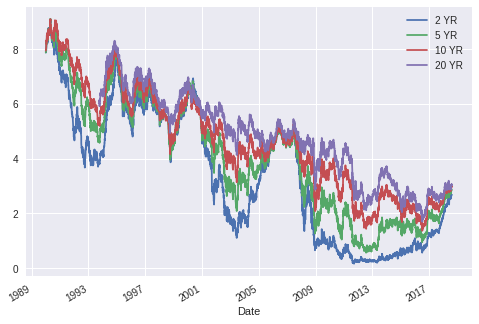

In [0]:
seriesName = 'Condor'
previousTradingDays = 252*10

# Time Series seed
json_ts =  {
   "calType" : "",
    "seriesName" : seriesName,
    "colName" : "Value",
  "dates": [],  
  "vals" : []
}

# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)

columns_fly = [columns[i] for i in cols]
df_rates[columns_fly].plot()


Here is where we partition the training and testing data


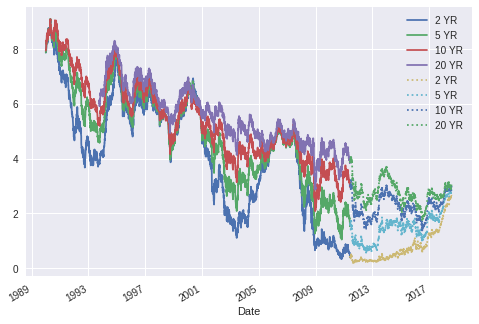

In [0]:
# take 3/4 of history as training, the rest to test
# feel free to change it -- look what happens if you pick only 50% 
# of training !
training_set = int(len(df_rates)*3/4)
testing_set = len(df_rates) - 1 - training_set


TimeSeriesTest = df_rates[columns_fly].iloc[:-training_set]
TimeSeries = df_rates[columns_fly].iloc[testing_set:]

ax = TimeSeries.plot()
TimeSeriesTest.plot(ax = ax, style = ':')


Johansen method to get mean revering series: (force pick the first one, which has the shortest half life)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


r values are: [0, 1]
----------------------------------
The 0 th cointegrating relation:
{'calibrationResult': {'Mu': 35.210864666317576, 'Sigma': 27.099713064395583, 'Lambda': 6.798928383625704, 'LogLikelihood': 8312.208133370956, 'ProcessType': 'Mean Reverting', 'LastPrice': 54.51583785426206, 'DaysPerYear': 365.25, 'HalfLife': 37.237045812874044, 'Std_band': 7.34902054352014}, 'timeSeries': {}, 'ts_string': None, 'time_ser_dates': None, 'time_ser_values': None}
Johansen Vector
[ 0.3740726  -1.          0.7864818  -0.09795475]
Johansen vector half life 37.237045812874044


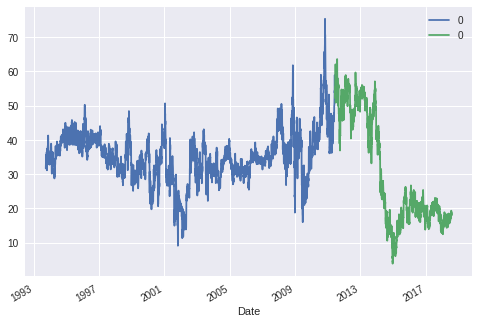

In [0]:


#
x = TimeSeries.dropna().as_matrix()
x_centered = x - np.mean(x, axis=0)

johansen = Johansen(x_centered, model=2, significance_level=2)
eigenvectors, r = johansen.johansen()

print ("r values are: {}".format(r))


#for k in r:
for k in [0]:
 
    
    print ("----------------------------------")
    print ("The",k,"th cointegrating relation:")
    
    j_ev = eigenvectors[:, k]/max(abs(eigenvectors[:,k])) 
    

    bb = pd.DataFrame(TimeSeries.dot(j_ev)) * 100
    test = pd.DataFrame(TimeSeriesTest.dot(j_ev)) * 100
    r_json = MarkovCalibration(bb)
    print (r_json)
    j_half_life = r_json['calibrationResult']['HalfLife']
    j_sigma = r_json['calibrationResult']['Sigma']
    j_mu = r_json['calibrationResult']['Mu']
    #cc = bb - mu
    print ("Johansen Vector")
    print (j_ev)
    print("Johansen vector half life", j_half_life)

    
    ax = bb.plot() 
    test.plot(ax = ax)


from google.colab import files

johansen_pk = 'dqn_OUtrader_26_90_cl.pk'
bb.to_pickle(johansen_pk)
#agent.drawQspace()

Real life trading data:



35.25 27.099713064395583 37.237045812874044
3.7237045812874046


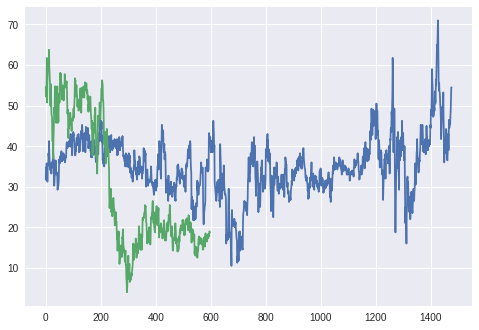

In [0]:


# posDV01 is the name that Fixed Income traders give to the number of units allocated to the trade.
# posDV01 of 10 means that 10 dollars per 'bp' are being traded (you can use your own size -- put 100k ?)
posDV01 = 10

# j_tick_size is the typical quoting step for a trade -- usually a 1/4 of a bp in Fixed Income land.
# but if you can get a smaller one - change it.
j_tick_size = 0.25

# define price spaces
j_mu_rounded = np.round(j_mu/j_tick_size)*j_tick_size
pOU = PSpaceOU(mu = j_mu_rounded, sigma = j_sigma, tick_size = j_tick_size, half_life_periods = j_half_life, lot_size = posDV01, std_mult = 5)
#pOU = PSpaceOU(mu = +6, sigma = 21.5, tick_size = 0.25, half_life_periods = 54, lot_size = posDV01, std_mult = 5)
ps = PHASpace(pOU, M =10, K = 5)
print(j_mu_rounded, j_sigma, j_half_life)

# the code above seems to converge only if the mean reversion speed is about 10 periods (or less)
# hence why I re-sample it to accomodate this hurdle.
one_year = (int(365/ pOU.sampling_frequency))
five_years = one_year * 5
print (pOU.sampling_frequency)
sample = max(1,int(pOU.sampling_frequency))
agent = DQNAgent(ps, kappa = 1)

# jPath has the downsampled training period (blue in the following graph)
jPath = (bb[0].sort_index().dropna()).iloc[::sample].values

#jPath = (bb[0].sort_index().dropna()).iloc[::int(pOU.sampling_frequency)].values
jPathOrg = [pOU.PriceOrg(num) for num in jPath]
plt.plot(jPathOrg)

# jPathTest has the downsampled testing period (green in the graph)
jPathTest = (test[0].sort_index().dropna()).iloc[::sample].values
jPathTestOrg = [pOU.PriceOrg(num) for num in jPathTest]
plt.plot(jPathTestOrg)




## RoboTrader

preload a trained model, or...

Saving dqn_usd_rates_condor (4).h5 to dqn_usd_rates_condor (4) (2).h5


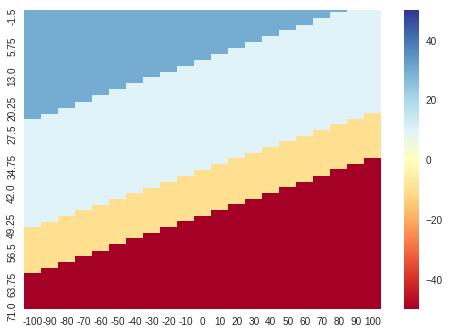

In [0]:
# preload trained model

from google.colab import files
modelWeightsName = 'dqn_usd_rates_condor.h5'
files.upload()
modelWeightsNameLast = 'dqn_usd_rates_condor (4).h5'
agent.model.load_weights(modelWeightsNameLast)
agent.drawQspace()



... train a new one from scratch

In [0]:

# if there is no available mode, train a new one
pricePath = agent.phaSp.PriceSampler(5000)
for i in range(0,10):
  agent.LearningSimple(10000)
  #  pnl = agent.OutOfSample(five_years*10)
  pnl = agent.OutOfSamplePath(pricePath)
  
  plt.plot(pnl.cumsum())
  plt.show()
  sharpe = pnl.cumsum().mean()[0] / pnl.cumsum().std()[0] * np.sqrt(one_year)
  print ('-------------------')
  print (i, sharpe, pnl.cumsum()[-1:][0])
  agent.drawQspace()

plt.show()
from google.colab import files


agent.model.save_weights(modelWeightsName)
#agent.drawQspace()


## Neanderthal Rules:



20.55195891295972 49.94804108704028


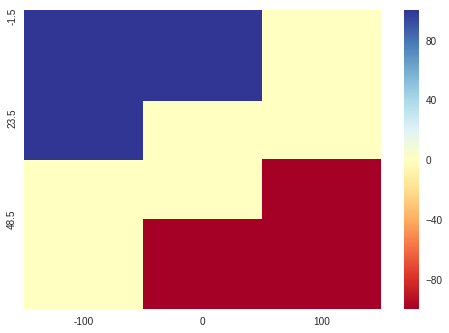

In [0]:

pd.options.mode.chained_assignment = None

# Setting up 2-std rule:
multiple = 2
sell = multiple * agent.phaSp.pSpace.std_band+agent.phaSp.pSpace.P_eOrg
buy = - multiple * agent.phaSp.pSpace.std_band+agent.phaSp.pSpace.P_eOrg
take_profit = agent.phaSp.pSpace.P_eOrg
print( buy, sell)

# get a clean map
AlgoTemp = agent.mapQaction()*0

#this posDV01 should be the same as the total holding period
# of the RoboTrader to be able to compare them
posDV01 = 100
AlgoT = AlgoTemp[[(0, -posDV01), (0,0), (0,posDV01)]] 
#
# if short, take profit at mid
AlgoT[0][-posDV01][AlgoT.index <= take_profit] = posDV01

# if long, take profit at mid
AlgoT[0][posDV01][AlgoT.index >= take_profit] = -posDV01

# if no position, get long at lower than 2 std
AlgoT[0][0][AlgoT.index <= buy] = posDV01

# if no position, get short at greater than 2 std
AlgoT[0][0][AlgoT.index >= sell] = -posDV01
ax = sns.heatmap(AlgoT[0], yticklabels=100, cmap = 'RdYlBu')
#, annot=True, fmt = ".0f")
plt.show()




In [0]:
pricePathOrg = jPathOrg


def plotPNL(pricePathOrg, agent, AlgoT):
    pricePath = agent.phaSp.pSpace.PriceSamplerPath(pricePathOrg)
    pnl = agent.OutOfSamplePath(pricePath)

    fig = plt.figure()
    ax = fig.add_subplot(211)

    ax.plot(pnl.cumsum())

    sharpe_nn = pnl.cumsum().mean()[0] / pnl.cumsum().std()[0] * np.sqrt(one_year)
    print ('-------------------')
    print ('NN', sharpe_nn, pnl.cumsum()[-1:])
    print ('-------------------')


    pnl = agent.OutOfSampleQmapPath(pricePathOrg,AlgoT)
    sharpe_qm = pnl.cumsum().mean()[0] / pnl.cumsum().std()[0] * np.sqrt(one_year)

    ax.plot(pnl.cumsum())
    print ('-------------------')
    print ('Qmap', sharpe_qm, pnl.cumsum()[-1:][0])
    print ('-------------------')

    print ('Sharpe ratio NN/Qmap', sharpe_nn/ sharpe_qm)
    ax2 = fig.add_subplot(212)
    ax2.plot(pricePathOrg, color = 'purple', linestyle = ':')
    plt.show()




## Out of Sample (Simulated Data)

-------------------
NN 16.44323273727542             0
4999  91640.0
-------------------
-------------------
Qmap 16.11532893108257 4999    78663.77551
Name: 0, dtype: float64
-------------------
Sharpe ratio NN/Qmap 1.0203473231973816


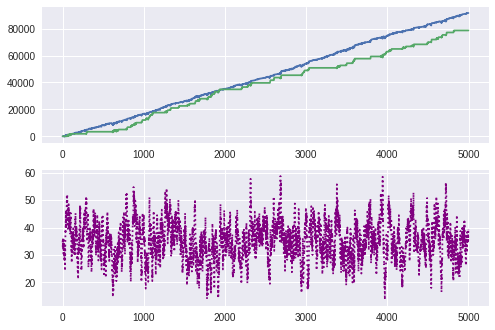

In [0]:
horizon = 5000
plotPNL(agent.phaSp.PriceSamplerOrg(horizon),agent, AlgoT)  

 

## BackTest

-------------------
NN 14.308079654619156             0
1474  14237.5
-------------------
-------------------
Qmap 10.97764073414653 1474    9991.156463
Name: 0, dtype: float64
-------------------
Sharpe ratio NN/Qmap 1.3033838509683708


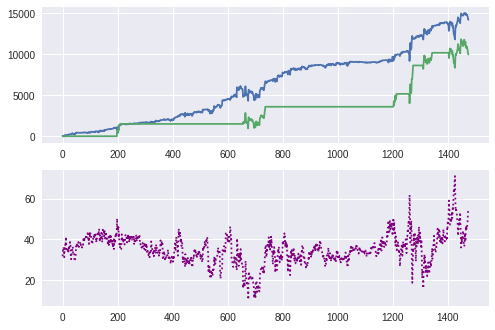

In [0]:
plotPNL(jPathOrg,agent, AlgoT)  




## Testing historical data

-------------------
NN 25.301429660243834           0
595  2590.0
-------------------
-------------------
Qmap 16.46697767740832 595    3571.598639
Name: 0, dtype: float64
-------------------
Sharpe ratio NN/Qmap 1.5364950482052233


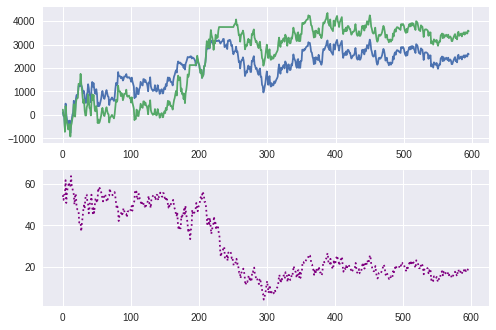

In [0]:
plotPNL(jPathTestOrg,agent, AlgoT) 